In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# generation of some house sizes between 1000 and 3500 (typical sq ft of house)
num_house =160
np.random.seed(42)
house_size = np.random.randint(low=1000, high=3500, size=num_house)

In [3]:
np.random.seed(42)
house_price = house_size * 100.0 + np.random.randint(low=20000, high=70000, size=num_house)

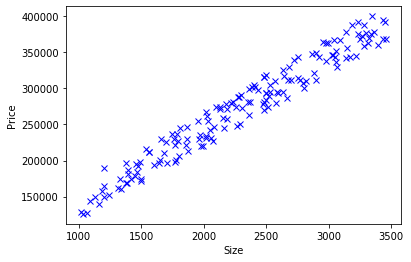

In [4]:
plt.plot(house_size, house_price, "bx") # bx = blue x
plt.ylabel("Price")
plt.xlabel("Size")
plt.show()

In [5]:
#noemalize values to prevent under/overflows.

def normalize(array):
    return (array-array.mean())/array.std()

In [6]:
#train data
num_train_samples = math.floor(num_house * 0.7)

train_house_size = np.array(house_size[:num_train_samples])
train_price = np.asanyarray(house_price[:num_train_samples])

train_house_size_norm = normalize(train_house_size)
train_price_norm = normalize(train_price)

In [7]:
#test data

test_house_size = np.array(house_size[num_train_samples:])
test_house_price =  np.array(house_price[num_train_samples:])

test_house_size_norm = normalize(test_house_size)
test_house_price_norm = normalize(test_house_price)

In [8]:
tf_house_size = tf.placeholder("float", name="house_size")
tf_price =tf.placeholder("float", name="price")

In [9]:
tf_size_factor = tf.Variable(np.random.randn(), name="siz_factor")
tf_price_offset = tf.Variable(np.random.randn(), name="price_offset")

In [10]:
#inference function
tf_price_pred = tf.add(tf.multiply(tf_size_factor, tf_house_size), tf_price_offset)

In [11]:
tf_cost = tf.reduce_sum(tf.pow(tf_price_pred-tf_price,2))/(2*num_train_samples)

In [12]:
learning_rate = 0.1

In [13]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(tf_cost)

iteration 0002 cost= 0.720058978 size_factor= 0.091779955 price_offset= -0.78197587
iteration 0004 cost= 0.488989949 size_factor= 0.2530591 price_offset= -0.6400547
iteration 0006 cost= 0.334198922 size_factor= 0.38506955 price_offset= -0.52387947
iteration 0008 cost= 0.230510592 size_factor= 0.4931228 price_offset= -0.42877954
iteration 0010 cost= 0.161057353 size_factor= 0.5815667 price_offset= -0.350931
iteration 0012 cost= 0.114538930 size_factor= 0.65396035 price_offset= -0.2872049
iteration 0014 cost= 0.083384469 size_factor= 0.713216 price_offset= -0.23503916
iteration 0016 cost= 0.062521778 size_factor= 0.76171756 price_offset= -0.19233663
iteration 0018 cost= 0.048552584 size_factor= 0.8014175 price_offset= -0.1573807
iteration 0020 cost= 0.039200630 size_factor= 0.8339127 price_offset= -0.1287661
iteration 0022 cost= 0.032940891 size_factor= 0.86051065 price_offset= -0.10534229
iteration 0024 cost= 0.028751854 size_factor= 0.882282 price_offset= -0.08616769
iteration 0026 cos

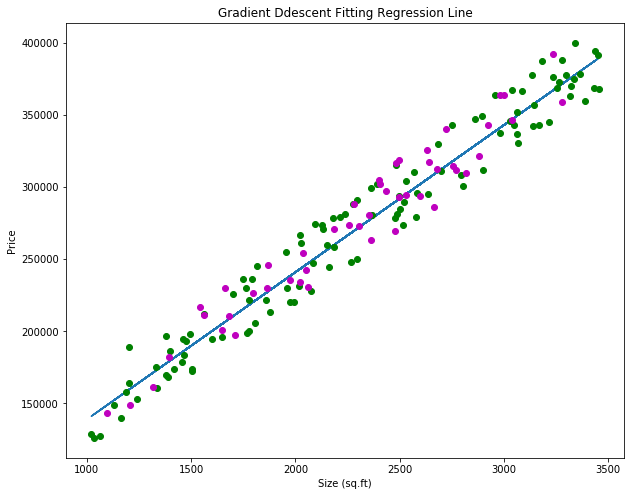

In [18]:
#initialize the variables
init = tf.global_variables_initializer()

#launch graph in the session
with tf.compat.v1.Session() as sess:
   # %matplotlib inline
    sess.run(init)

    display_every =2
    num_training_iter = 50
    
    # calculate the number of lines to animate
    fit_num_plots = math.floor(num_training_iter/display_every)
    #add storage of factor and offset values from each epoch
    fit_size_factor = np.zeros(fit_num_plots)
    fit_price_offsets = np.zeros(fit_num_plots)
    fit_plot_idx = 0
     
    
    # keep iterating the training data
    for iteration in range(num_training_iter):
        
        for(x,y) in zip(train_house_size_norm, train_price_norm):
            sess.run(optimizer, feed_dict={tf_house_size : x, tf_price: y})
        
        if (iteration+1) % display_every == 0:
            c = sess.run(tf_cost,  feed_dict={tf_house_size: train_house_size_norm, tf_price:train_price_norm})
            print("iteration",'%04d'%(iteration+1),"cost=","{:.9f}".format(c),"size_factor=",sess.run(tf_size_factor),"price_offset=",sess.run(tf_price_offset))   
    
            #save the fit size_factor and price_offset to allow animation of learning process
            fit_size_factor[fit_plot_idx] = sess.run(tf_size_factor)
            fit_price_offsets[fit_plot_idx] = sess.run(tf_price_offset)
            fit_plot_idx = fit_plot_idx +1
        
        
    print("Optimization Finished")
    training_cost = sess.run(tf_cost, feed_dict={tf_house_size:train_house_size_norm, tf_price:train_price_norm})
    print("Training cost=", training_cost, "size_factor=", sess.run(tf_size_factor), "price_offset=", sess.run(tf_price_offset),"\n")
    
    train_house_size_mean = train_house_size.mean()              
    train_house_size_std = train_house_size.std()
    
    train_price_mean = train_price.mean()
    train_price_std =  train_price.std()
    
    fig, ax = plt.subplots()
    line, = ax.plot(house_size, house_price)

    plt.rcParams["figure.figsize"]=(10,8)
    plt.title("Gradient Ddescent Fitting Regression Line")
    plt.ylabel("Price")
    plt.xlabel("Size (sq.ft)")
    plt.plot(train_house_size, train_price, 'go', label='Training data')
    plt.plot(test_house_size, test_house_price, 'mo', label='Testing data')
    
    def animate(i):
        line.set_xdata(train_house_size_norm * train_house_size_std + train_house_size_mean)
        line.set_ydata((fit_size_factor[i] * train_house_size_norm + fit_price_offsets[i])*train_price_std+train_price_mean)
        return line,
    
    def initAnim():
        line.set_ydata(np.zeros(shape=house_price.shape[0]))
        return line,
    
    ani = animation.FuncAnimation(fig, animate, frames = np.arange(0, fit_plot_idx), init_func=initAnim,
                                 interval=3000, blit=True)
    #HTML(ani.to_jshtml())
    #plt.show()
    HTML(ani.to_html5_video())